In [33]:
import os
import pandas as pd
import numpy as np
import contractions
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import json

In [34]:
video_df = pd.read_csv('data/video_corpus_english.csv')
video_df.head()

,VideoID,Description
0,mv89psg6zh4_33_46,A bird in a sink keeps getting under the runni...
1,mv89psg6zh4_33_46,A bird is bathing in a sink.
2,mv89psg6zh4_33_46,A bird is splashing around under a running fau...
3,mv89psg6zh4_33_46,A bird is bathing in a sink.
4,mv89psg6zh4_33_46,A bird is standing in a sink drinking water th...


### Explore the Captions
<blockquote>Preparing the input for the next stage of the video captioning also includes preparing the acutal description of the video.</blockquote>
<blockquote>I have to find out the <strong>maximum</strong> and <strong>mininmum</strong> length of the captions, and also the <strong>mean</strong>, prepare a vocabulary containing the top words found in the captions to exclude possible outliers.</blockquote>

In [35]:
video_df[~video_df['Description'].apply(lambda x: isinstance(x, str))]

,VideoID,Description
49794,SKhmFSV-XB0_12_18,NaN


In [36]:
video_df = video_df.drop(index=49794)

In [37]:
def clean_description(text):
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return f"<bos> {text} <eos>"

In [38]:
video_df['Description'] = video_df['Description'].apply(clean_description)
video_df['TextLength'] = video_df['Description'].str.len()

In [39]:
max_len = video_df['TextLength'].max()
min_len = video_df['TextLength'].min()
mean_len = video_df['TextLength'].mean()

print(f"Max length: {max_len}")
print(f"Min length: {min_len}")
print(f"Mean length: {mean_len:.2f}")

Max length: 712
Min length: 15
Mean length: 46.20


In [40]:
video_df.head()

,VideoID,Description,TextLength
0,mv89psg6zh4_33_46,<bos> a bird in a sink keeps getting under the...,80
1,mv89psg6zh4_33_46,<bos> a bird is bathing in a sink <eos>,39
2,mv89psg6zh4_33_46,<bos> a bird is splashing around under a runni...,61
3,mv89psg6zh4_33_46,<bos> a bird is bathing in a sink <eos>,39
4,mv89psg6zh4_33_46,<bos> a bird is standing in a sink drinking wa...,88


In [41]:
tokenizer = Tokenizer(num_words=1500, oov_token='<unk>')
tokenizer.fit_on_texts(video_df['Description'])
sequences = tokenizer.texts_to_sequences(video_df['Description'])

In [42]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [43]:
token_lengths = [len(seq) for seq in sequences]
video_df['TokenLength'] = token_lengths

In [44]:
print(f"Max token length: {np.max(token_lengths)}")
print(f"Min token length: {np.min(token_lengths)}")
print(f"Mean token length: {np.mean(token_lengths):.2f}")
print(f"90th percentile: {np.percentile(token_lengths, 90):.0f}")
print(f"95th percentile: {np.percentile(token_lengths, 95):.0f}")

Max token length: 139
Min token length: 3
Mean token length: 9.10
90th percentile: 12
95th percentile: 14


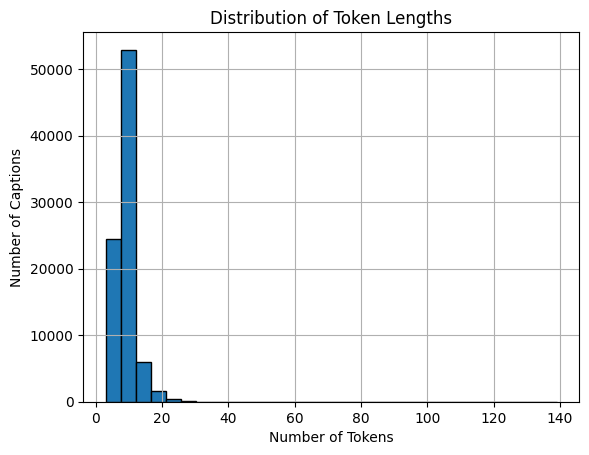

In [45]:
plt.hist(token_lengths, bins=30, edgecolor='black')
plt.title("Distribution of Token Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Captions")
plt.grid(True)
plt.show()

In [46]:
video_df.head()

,VideoID,Description,TextLength,TokenLength
0,mv89psg6zh4_33_46,<bos> a bird in a sink keeps getting under the...,80,16
1,mv89psg6zh4_33_46,<bos> a bird is bathing in a sink <eos>,39,9
2,mv89psg6zh4_33_46,<bos> a bird is splashing around under a runni...,61,11
3,mv89psg6zh4_33_46,<bos> a bird is bathing in a sink <eos>,39,9
4,mv89psg6zh4_33_46,<bos> a bird is standing in a sink drinking wa...,88,18


In [47]:
MAXLEN = 15
MINLEN = 5
video_df = video_df[(video_df['TokenLength'] >= MINLEN) & (video_df['TokenLength'] <= MAXLEN)]

In [48]:
sequences = tokenizer.texts_to_sequences(video_df['Description'])
padded_sequences = pad_sequences(sequences, maxlen=MAXLEN, padding='post', truncating='post')

In [49]:
video_df['PaddedSequence'] = list(padded_sequences)

In [50]:
video_df.head()

,VideoID,Description,TextLength,TokenLength,PaddedSequence
1,mv89psg6zh4_33_46,<bos> a bird is bathing in a sink <eos>,39,9,"[3, 2, 253, 5, 554, 9, 2, 465, 4, 0, 0, 0, 0, ..."
2,mv89psg6zh4_33_46,<bos> a bird is splashing around under a runni...,61,11,"[3, 2, 253, 5, 1, 81, 318, 2, 47, 903, 4, 0, 0..."
3,mv89psg6zh4_33_46,<bos> a bird is bathing in a sink <eos>,39,9,"[3, 2, 253, 5, 554, 9, 2, 465, 4, 0, 0, 0, 0, ..."
5,mv89psg6zh4_33_46,<bos> a faucet is running while a bird stands ...,69,14,"[3, 2, 903, 5, 47, 90, 2, 253, 1087, 9, 6, 465..."
6,mv89psg6zh4_33_46,<bos> a bird is playing in a sink with running...,58,12,"[3, 2, 253, 5, 11, 9, 2, 465, 15, 47, 32, 4, 0..."


In [51]:
max_len = video_df['TokenLength'].max()
min_len = video_df['TokenLength'].min()
mean_len = video_df['TokenLength'].mean()

print("Token Length:")
print(f"Max length: {max_len}")
print(f"Min length: {min_len}")
print(f"Mean length: {mean_len:.2f}")

Token Length:
Max length: 15
Min length: 5
Mean length: 8.75


In [52]:
def check_len(text):
    return len(text)

In [53]:
video_df['PSLength'] = video_df['PaddedSequence'].apply(check_len)

In [54]:
video_df.head()

,VideoID,Description,TextLength,TokenLength,PaddedSequence,PSLength
1,mv89psg6zh4_33_46,<bos> a bird is bathing in a sink <eos>,39,9,"[3, 2, 253, 5, 554, 9, 2, 465, 4, 0, 0, 0, 0, ...",15
2,mv89psg6zh4_33_46,<bos> a bird is splashing around under a runni...,61,11,"[3, 2, 253, 5, 1, 81, 318, 2, 47, 903, 4, 0, 0...",15
3,mv89psg6zh4_33_46,<bos> a bird is bathing in a sink <eos>,39,9,"[3, 2, 253, 5, 554, 9, 2, 465, 4, 0, 0, 0, 0, ...",15
5,mv89psg6zh4_33_46,<bos> a faucet is running while a bird stands ...,69,14,"[3, 2, 903, 5, 47, 90, 2, 253, 1087, 9, 6, 465...",15
6,mv89psg6zh4_33_46,<bos> a bird is playing in a sink with running...,58,12,"[3, 2, 253, 5, 11, 9, 2, 465, 15, 47, 32, 4, 0...",15


In [55]:
seq = video_df['PaddedSequence']
print(type(seq))

<class 'pandas.core.series.Series'>


In [56]:
max_len = video_df['PSLength'].max()
min_len = video_df['PSLength'].min()
mean_len = video_df['PSLength'].mean()

print("Padded Sequence Length:")
print(f"Max length: {max_len}")
print(f"Min length: {min_len}")
print(f"Mean length: {mean_len:.2f}")

Padded Sequence Length:
Max length: 15
Min length: 15
Mean length: 15.00


In [57]:
video_df = video_df.drop(columns = ['TokenLength','PSLength','TextLength'], axis=1)

In [58]:
print(f"Total number of rows in the video English corpus: {len(video_df)}")

Total number of rows in the video English corpus: 82242


In [60]:
# video_df.to_csv("data/final_video_corpus.csv", index=False)
video_df['PaddedSequence'] = video_df['PaddedSequence'].apply(lambda x: json.dumps(x.tolist()))
video_df.to_csv('data/final_video_corpus.csv', index=False)

In [29]:
num_decoder_tokens = len(tokenizer.word_index) + 1
num_decoder_tokens

13293